<a href="https://colab.research.google.com/github/jwonne/RL_Shared-Control/blob/main/JW_pytorch_realnvp_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import torch
import numpy as np
import pandas as pd

from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt


In [3]:
available = torch.cuda.is_available()
curr_device = torch.cuda.current_device()
device = torch.device("cuda:0" if available else "cpu")
device_count = torch.cuda.device_count()
device_name =  torch.cuda.get_device_name(0)

print(f'Cuda available: {available}')
print(f'Current device: {curr_device}')
print(f'Device: {device}')
print(f'Device count: {device_count}')
print(f'Device name: {device_name}')

Cuda available: True
Current device: 0
Device: cuda:0
Device count: 1
Device name: Tesla T4


In [4]:
# (Adapted) Code from PyTorch's Resnet impl: https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py

def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            # norm_layer = nn.BatchNorm2d
            norm_layer = nn.InstanceNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            #norm_layer = nn.BatchNorm2d
            norm_layer = nn.InstanceNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [5]:
class MyBatchNorm2d(nn.modules.batchnorm._NormBase):
    ''' Partially based on:
        https://pytorch.org/docs/stable/_modules/torch/nn/modules/batchnorm.html#BatchNorm2d
        https://discuss.pytorch.org/t/implementing-batchnorm-in-pytorch-problem-with-updating-self-running-mean-and-self-running-var/49314/5
    '''
    def __init__(
        self,
        num_features,
        eps=1e-5,
        momentum=0.005,
        device=None,
        dtype=None
    ):
        factory_kwargs = {'device': device, 'dtype': dtype, 'affine': False, 'track_running_stats': True}
        super(MyBatchNorm2d, self).__init__(
            num_features, eps, momentum, **factory_kwargs
        )

    def _check_input_dim(self, input):
        if input.dim() != 4:
            raise ValueError("expected 4D input (got {}D input)".format(input.dim()))

    def forward(self, input, validation=False):
        self._check_input_dim(input)

        if self.training:
            # Note: Need to detatch `running_{mean,var}` so don't backwards propagate through them
            unbiased_var, tmean = torch.var_mean(input, [0, 2, 3], unbiased=True)
            mean = torch.mean(input, [0, 2, 3]) # along channel axis
            unbiased_var = torch.var(input, [0, 2, 3], unbiased=True) # along channel axis
            running_mean = (1.0 - self.momentum) * self.running_mean.detach() + self.momentum * mean

            # Strange: PyTorch impl. of running variance uses biased_variance for the batch calc but
            # *unbiased_var* for the running_var!
            # https://github.com/pytorch/pytorch/blob/master/aten/src/ATen/native/Normalization.cpp#L190
            running_var = (1.0 - self.momentum) * self.running_var.detach() + self.momentum * unbiased_var

            # BK: Modification from the paper to use running mean/var instead of batch mean/var
            # change shape
            current_mean = running_mean.view([1, self.num_features, 1, 1]).expand_as(input)
            current_var = running_var.view([1, self.num_features, 1, 1]).expand_as(input)

            denom = (current_var + self.eps)
            y = (input - current_mean) / denom.sqrt()

            self.running_mean = running_mean
            self.running_var = running_var

            return y, -0.5 * torch.log(denom)
        else:
            current_mean = self.running_mean.view([1, self.num_features, 1, 1]).expand_as(input)
            current_var = self.running_var.view([1, self.num_features, 1, 1]).expand_as(input)

            if validation:
                denom = (current_var + self.eps)
                y = (input - current_mean) / denom.sqrt()
            else:
                # Reverse operation for testing
                denom = (current_var + self.eps)
                y = input * denom.sqrt() + current_mean

            return y, -0.5 * torch.log(denom)

In [6]:
class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = tuple([-1] + list(shape))

    def forward(self, x):
        return torch.reshape(x, self.shape)

def dense_backbone(shape, network_width):
    input_width = shape[0] * shape[1] * shape[2]
    return nn.Sequential(
        nn.Flatten(),
        nn.Linear(input_width, network_width),
        nn.ReLU(),
        nn.Linear(network_width, network_width),
        nn.ReLU(),
        nn.Linear(network_width, network_width),
        nn.ReLU(),
        nn.Linear(network_width, input_width),
        Reshape(shape)
    )

def bottleneck_backbone(in_planes, planes):
    return nn.Sequential(
        conv3x3(in_planes, planes),
        BasicBlock(planes, planes),
        BasicBlock(planes, planes),
        conv3x3(planes, in_planes),
    )

check_mask = {}
check_mask_device = {}
def checkerboard_mask(shape, to_device=True):
    global check_mask, check_mask_device
    if shape not in check_mask:
        check_mask[shape] = 1 - np.indices(shape).sum(axis=0) % 2
        check_mask[shape] = torch.Tensor(check_mask[shape])

    if to_device and shape not in check_mask_device:
        check_mask_device[shape] = check_mask[shape].to(device)

    return check_mask_device[shape] if to_device else check_mask[shape]

chan_mask = {}
chan_mask_device = {}
def channel_mask(shape, to_device=True):
    assert len(shape) == 3, shape
    assert shape[0] % 2 == 0, shape
    global chan_mask, chan_mask_device
    if shape not in chan_mask:
        chan_mask[shape] = torch.cat([torch.zeros((shape[0] // 2, shape[1], shape[2])),
                                      torch.ones((shape[0] // 2, shape[1], shape[2])),],
                                      dim=0)
        assert chan_mask[shape].shape == shape, (chan_mask[shape].shape, shape)

    if to_device and shape not in chan_mask_device:
        chan_mask_device[shape] = chan_mask[shape].to(device)

    return chan_mask_device[shape] if to_device else chan_mask[shape]

In [7]:
class NormalizingFlowMNist(nn.Module):
    EPSILON = 1e-5

    def __init__(self, num_coupling, num_final_coupling, planes):
        super(NormalizingFlowMNist, self).__init__()
        self.num_coupling = num_coupling
        self.num_final_coupling = num_final_coupling
        self.shape = (1, 28, 28)

        self.planes = planes
        self.s = nn.ModuleList()
        self.t = nn.ModuleList()
        self.norms = nn.ModuleList()

        # Learnable scalar scaling parameters for outputs of S and T
        self.s_scale = nn.ParameterList()
        self.t_scale = nn.ParameterList()
        self.t_bias = nn.ParameterList()
        self.shapes = []

        shape = self.shape
        for i in range(num_coupling):
            self.s.append(dense_backbone(shape, planes))
            self.t.append(dense_backbone(shape, planes))

            self.s_scale.append(torch.nn.Parameter(torch.zeros(shape), requires_grad=True))
            self.t_scale.append(torch.nn.Parameter(torch.zeros(shape), requires_grad=True))
            self.t_bias.append(torch.nn.Parameter(torch.zeros(shape), requires_grad=True))

            self.norms.append(MyBatchNorm2d(shape[0]))

            self.shapes.append(shape)

            if i % 6 == 2:
                shape = (4 * shape[0], shape[1] // 2, shape[2] // 2)

            if i % 6 == 5 or self.num_coupling - 1 == i:
                # Factoring out half the channels
                shape = (shape[0] // 2, shape[1], shape[2])
                planes = 2 * planes

        # Final coupling layers checkerboard
        for i in range(num_final_coupling):
            self.s.append(dense_backbone(shape, planes))
            self.t.append(dense_backbone(shape, planes))

            self.s_scale.append(torch.nn.Parameter(torch.zeros(shape), requires_grad=True))
            self.t_scale.append(torch.nn.Parameter(torch.zeros(shape), requires_grad=True))
            self.t_bias.append(torch.nn.Parameter(torch.zeros(shape), requires_grad=True))

            self.norms.append(MyBatchNorm2d(shape[0]))

            self.shapes.append(shape)

        self.validation = False


    def validate(self):
        self.eval()
        self.validation = True

    def train(self, mode=True):
        nn.Module.train(self, mode)
        self.validation = False

    def forward(self, x):
        if self.training or self.validation:
            s_vals = []
            norm_vals = []
            y_vals = []

            for i in range(self.num_coupling):
                shape = self.shapes[i]
                mask = checkerboard_mask(shape) if i % 6 < 3 else channel_mask(shape)
                mask = mask if i % 2 == 0 else (1 - mask)

                t = (self.t_scale[i]) * self.t[i](mask * x) + (self.t_bias[i])
                s = (self.s_scale[i]) * torch.tanh(self.s[i](mask * x))
                y = mask * x + (1 - mask) * (x * torch.exp(s) + t)
                s_vals.append(torch.flatten((1 - mask) * s))

                if self.norms[i] is not None:
                    y, norm_loss = self.norms[i](y, validation=self.validation)
                    norm_vals.append(norm_loss)

                if i % 6 == 2:
                    y = torch.nn.functional.pixel_unshuffle(y, 2)

                if i % 6 == 5 or self.num_coupling -1 == i:
                    factor_channels = y.shape[1] // 2
                    y_vals.append(torch.flatten(y[:, factor_channels:, :, :], 1))
                    y = y[:, :factor_channels, :, :]

                x = y

            # Final checkboard coupling
            for i in range(self.num_coupling, self.num_coupling + self.num_final_coupling):
                shape = self.shapes[i]
                mask = checkerboard_mask(shape)
                mask = mask if i % 2 == 0 else (1 - mask)

                t = (self.t_scale[i]) * self.t[i](mask * x) + (self.t_bias[i])
                s = (self.s_scale[i]) * torch.tanh(self.s[i](mask * x))
                y = mask * x + (1 - mask) * (x * torch.exp(s) + t)
                s_vals.append(torch.flatten((1 - mask) * s))

                if self.norms[i] is not None:
                    y, norm_loss = self.norms[i](y, validation=self.validation)
                    norm_vals.append(norm_loss)

                x = y

            y_vals.append(torch.flatten(y, 1))

            # Return outputs and vars needed for determinant
            return (torch.flatten(torch.cat(y_vals, 1), 1),
                    torch.cat(s_vals),
                    torch.cat([torch.flatten(v) for v in norm_vals]) if len(norm_vals) > 0 else torch.zeros(1),
                    torch.cat([torch.flatten(s) for s in self.s_scale]))
        else:
            y = x
            y_remaining = y

            layer_vars = np.prod(self.shapes[-1])
            y = torch.reshape(y_remaining[:, -layer_vars:], (-1,) + self.shapes[-1])
            y_remaining = y_remaining[:, :-layer_vars]

            # Reversed final checkboard coupling
            for i in reversed(range(self.num_coupling, self.num_coupling + self.num_final_coupling)):
                shape = self.shapes[i]
                mask = checkerboard_mask(shape)
                mask = mask if i % 2 == 0 else (1 - mask)

                if self.norms[i] is not None:
                    y, _ = self.norms[i](y)

                t = (self.t_scale[i]) * self.t[i](mask * y) + (self.t_bias[i])
                s = (self.s_scale[i]) * torch.tanh(self.s[i](mask * y))
                x = mask * y + (1 - mask) * ((y - t) * torch.exp(-s))

                y = x

            layer_vars = np.prod(shape)
            y = torch.cat((y, torch.reshape(y_remaining[:, -layer_vars:], (-1,) + shape)), 1)
            y_remaining = y_remaining[:, :-layer_vars]

            # Multi-scale coupling layers
            for i in reversed(range(self.num_coupling)):
                shape = self.shapes[i]
                mask = checkerboard_mask(shape) if i % 6 < 3 else channel_mask(shape)
                mask = mask if i % 2 == 0 else (1 - mask)

                if self.norms[i] is not None:
                    y, _ = self.norms[i](y)

                t = (self.t_scale[i]) * self.t[i](mask * y) + (self.t_bias[i])
                s = (self.s_scale[i]) * torch.tanh(self.s[i](mask * y))
                x = mask * y + (1 - mask) * ((y - t) * torch.exp(-s))

                if i % 6 == 3:
                    x = torch.nn.functional.pixel_shuffle(x, 2)

                y = x

                if i > 0 and i % 6 == 0:
                    layer_vars = np.prod(shape)
                    y = torch.cat((y, torch.reshape(y_remaining[:, -layer_vars:], (-1,) + shape)), 1)
                    y_remaining = y_remaining[:, :-layer_vars]

            assert np.prod(y_remaining.shape) == 0

            return x



In [8]:
PI = torch.tensor(np.pi).to(device)
def loss_fn(y, s, norms, scale, batch_size):
    # -log(zero-mean gaussian) + log determinant
    # -log p_x = log(pz(f(x))) + log(det(\partial f/\partial x))
    # -log p_x = 0.5 * y**2 + s1 + s2 + ... + batch_norm_scalers + l2_regularizers(scale)
    logpx = -torch.sum(0.5 * torch.log(2 * PI) + 0.5 * y**2)
    det = torch.sum(s)
    norms = torch.sum(norms)
    reg = 5e-5 * torch.sum(scale ** 2)
    loss = -(logpx + det + norms) + reg
    return torch.div(loss, batch_size), (-logpx, -det, -norms, reg)

# MNist Training

In [9]:
def pre_process(x):
    # Convert back to integer values
    x = x * 255.

    # Add random uniform [0, 1] noise to get a proper likelihood estimate
    # https://bjlkeng.github.io/posts/a-note-on-using-log-likelihood-for-generative-models/
    x = x + torch.rand(x.shape, device=x.device)


    # Apply transform to deal with boundary effects (see realNVP paper)
    #x = torch.logit(0.05 + 0.90 * x / 256)
    #return x
    return x / 255

def post_process(x):
    # Convert back to integer values
    #return torch.clip(torch.floor(256 / 0.90 * (torch.sigmoid(x) - 0.05)), min=0, max=255) / 255
    return torch.clip(x, min=0, max=1)

In [10]:
train_dataset = datasets.MNIST('data', train=True, download=True,
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                               ]))

# TODO FIX ME
# debug_data = []
# for i, x in enumerate(train_dataset):
#     if i >= 200:
#         break
#     debug_data.append(x)

test_dataset = datasets.MNIST('data', train=False, download=True,
                              transform=transforms.Compose([
                                  transforms.ToTensor(),
                              ]))

100%|██████████| 9912422/9912422 [00:00<00:00, 104892488.60it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 24807637.48it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28118637.62it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12467623.54it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [11]:
def train_loop(dataloader, model, loss_fn, optimizer, batch_size, report_iters=10, num_pixels=28*28):
    size = len(dataloader)
    prev = []
    for batch, (X, _) in enumerate(dataloader):
        # Transfer to GPU
        X = pre_process(X)
        X = X.to(device)

        # Compute prediction and loss
        y, s, norms, scale = model(X)
        loss, comps = loss_fn(y, s, norms, scale, batch_size)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1) # gradient_clipping = 1

        prev = [(name, x, x.grad) for name, x in model.named_parameters(recurse=True)]
        optimizer.step()

        if batch % report_iters == 0:
            loss, current = loss.item(), batch
            # Account for x/255 preprocessing
            loss += num_pixels * np.log(255)
            print(f"loss: {loss:.2f} = -logpx[{comps[0]:.1f}], -det[{comps[1]:.1f}], -norms[{comps[2]:.1f}], reg[{comps[3]:.4f}]"
                  f"; bits/pixel: {loss / num_pixels / np.log(2):>.2f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn, num_pixels=28*28):
    size = len(dataloader)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        model.validate()
        for X, _ in dataloader:
            X = pre_process(X)
            X = X.to(device)
            y, s, norms, scale = model(X)
            loss, _ = loss_fn(y, s, norms, scale, batch_size)
            test_loss += loss

        model.train()


    test_loss /= num_batches
    # Account for x/255 preprocessing
    test_loss += num_pixels * np.log(255)
    print(f"Test Error: \n Avg loss: {test_loss:.2f}; {test_loss / num_pixels / np.log(2):.2f} \n")
    return test_loss

In [12]:
learning_rate = 0.0005
batch_size = 128
epochs = 20

model = NormalizingFlowMNist(num_coupling=4, num_final_coupling=1, planes=256).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [13]:
model.train()

best_validation = None
PATH = '/content/drive/MyDrive/STDL_Assignment_1_Jinwon/Qs3'
for t in range(epochs):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer, batch_size)
    validation_loss = test_loop(test_loader, model, loss_fn)

    torch.save({
        'epoch': t,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': validation_loss,
    }, PATH + f'mnist-{t}.model')

    if best_validation is None or validation_loss < best_validation:
        best_validation = validation_loss
        best_path = PATH + f'mnist-{t}.model'

    scheduler.step()

print("Done - ", best_path)

Epoch 1
-------------------------------
loss: 5101.23 = -logpx[97901.9], -det[-0.0], -norms[-1021.5], reg[0.0000]; bits/pixel: 9.39  [    0/  469]
loss: 5029.86 = -logpx[99133.6], -det[-205.7], -norms[-11182.4], reg[0.0000]; bits/pixel: 9.26  [   10/  469]
loss: 4938.49 = -logpx[99370.6], -det[-2101.7], -norms[-21218.6], reg[0.0000]; bits/pixel: 9.09  [   20/  469]
loss: 4846.23 = -logpx[99032.0], -det[-3566.8], -norms[-31224.2], reg[0.0000]; bits/pixel: 8.92  [   30/  469]
loss: 4768.27 = -logpx[100241.3], -det[-4780.5], -norms[-41199.6], reg[0.0000]; bits/pixel: 8.77  [   40/  469]
loss: 4700.06 = -logpx[102500.9], -det[-5992.8], -norms[-50977.0], reg[0.0001]; bits/pixel: 8.65  [   50/  469]
loss: 4634.30 = -logpx[104799.2], -det[-7198.2], -norms[-60487.6], reg[0.0001]; bits/pixel: 8.53  [   60/  469]
loss: 4570.36 = -logpx[107012.9], -det[-8320.2], -norms[-69763.0], reg[0.0001]; bits/pixel: 8.41  [   70/  469]
loss: 4519.73 = -logpx[110429.2], -det[-9282.2], -norms[-78698.3], reg[0.

In [14]:
model = NormalizingFlowMNist(num_coupling=4, num_final_coupling=1, planes=256).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#checkpoint = torch.load('checkpoints/mnist-1.model')
checkpoint = torch.load(best_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

# Debug - Check that foward/reverse are (about) equal

In [15]:
# DEBUG - Checkmodel[s]
model.validate()

with torch.no_grad():
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False) #shuffle=True)
    for x, _ in train_loader:
        x_pre = pre_process(x).to(device)
        y, s, norms, scale = model(x_pre)
        break

model.train()
model.eval()

with torch.no_grad():
    xp = model(y)
    x_post = post_process(xp)

diff = x.to(device) - x_post
print(torch.any(torch.abs(diff) > 1 / 255))


tensor(True, device='cuda:0')


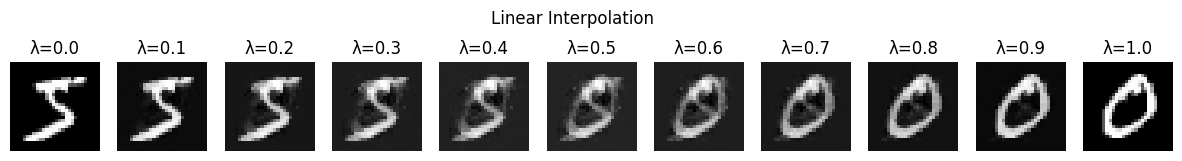

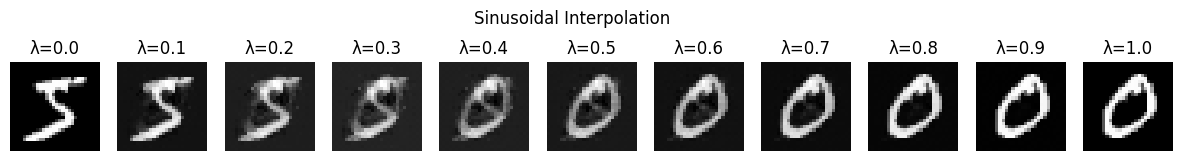

In [16]:
#Interpolation (Linear, Sinusoidal)
model.validate()

with torch.no_grad():
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False) #shuffle=True)
    for x, _ in train_loader:
        x_pre = pre_process(x).to(device)
        y, s, norms, scale = model(x_pre)
        break

#Get latent space
z1, _, _, _ = model(x_pre[0].unsqueeze(0))
z2, _, _, _ = model(x_pre[1].unsqueeze(0))

model.eval()

#Define lambda (0 to 1, step : 0.1)
lamb = tensor = torch.arange(0, 1.1, 0.1).to(device)
z_linear = (1 - lamb[:, None]) * z1 + lamb[:, None] * z2
z_sinusoidal = (1 - torch.sin(lamb[:, None] * np.pi / 2)) * z1 + torch.sin(lamb[:, None] * np.pi / 2) * z2

with torch.no_grad():
    x_linear = model(z_linear)
    x_sinusoidal = model(z_sinusoidal)

# Plot
plt.figure(figsize=(15, 2))
for i, x in enumerate(x_linear):
    plt.subplot(1, len(lamb), i + 1)
    plt.imshow(x[0].cpu().detach().numpy(), cmap='gray')
    plt.title(f'λ={lamb[i]:.1f}')
    plt.axis('off')
plt.suptitle('Linear Interpolation')
plt.show()
plt.figure(figsize=(15, 2))
for i, x in enumerate(x_sinusoidal):
    plt.subplot(1, len(lamb), i + 1)
    plt.imshow(x[0].cpu().detach().numpy(), cmap='gray')
    plt.title(f'λ={lamb[i]:.1f}')
    plt.axis('off')
plt.suptitle('Sinusoidal Interpolation')
plt.show()

In [17]:
print(diff.shape)
for i in range(batch_size):
    if torch.any(torch.abs(diff[i]) > 1 / 255):
        #print(diff[i])
        for j in range(28):
            for k in range(28):
                if torch.any(torch.abs(diff[i, 0, j, k]) > 1 / 255):
                    print(i, 1, j, k, diff[i, 0, j, k].cpu().numpy())
                    break
        break

torch.Size([128, 1, 28, 28])
81 1 10 13 -0.003921628


count    100352.000000
mean          0.034470
std           0.970233
min         -11.672347
25%          -0.405276
50%           0.026166
75%           0.456320
max          70.528587
dtype: float64


<Axes: >

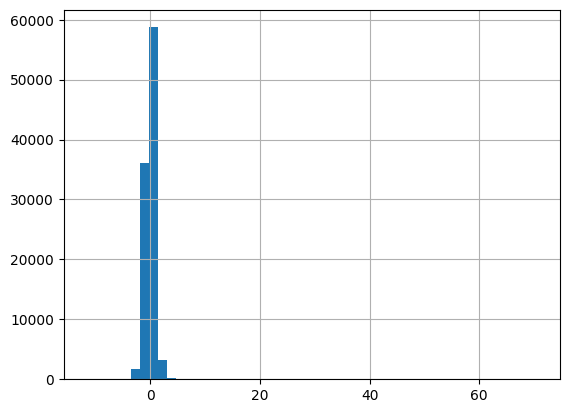

In [18]:
s = pd.Series(torch.flatten(y).cpu().numpy())
print(s.describe())
s.hist(bins=50)

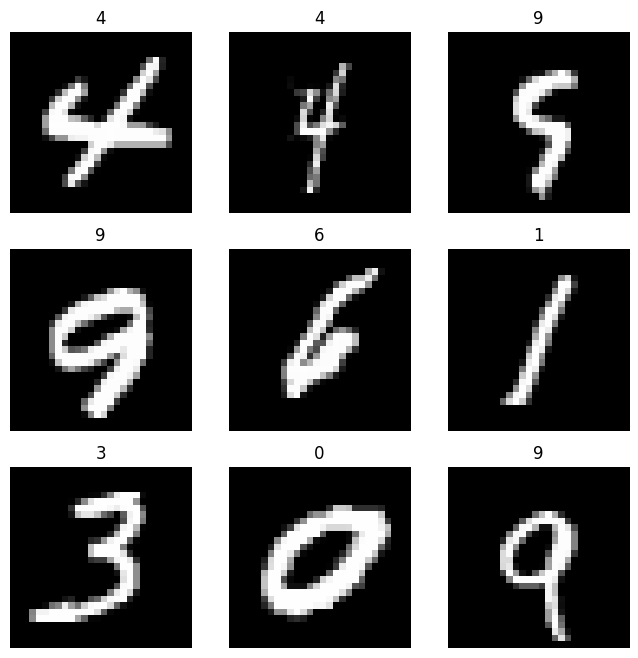

In [19]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(str(label))
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [20]:
model.eval()
with torch.no_grad():
    X = torch.Tensor(torch.randn((1, 28 * 28 * 1))).to(device)
    Y = model(X)
    print(X.shape)
    samples = post_process(Y).cpu().numpy()

torch.Size([1, 784])


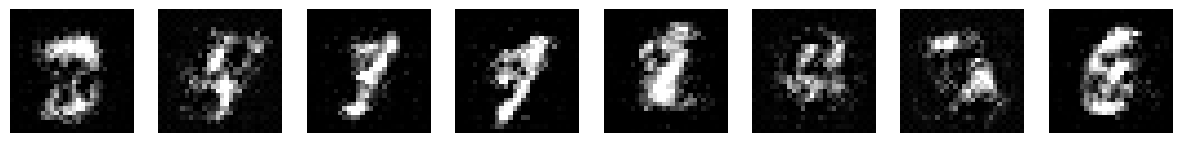

In [21]:
model.eval()

cols, rows = 8, 1
with torch.no_grad():
    X = torch.Tensor(torch.normal(torch.zeros(cols * rows, 28 * 28 * 1),
                                  torch.ones(cols * rows, 28 * 28 * 1))).to(device)
    Y = model(X)
    samples = post_process(Y).cpu().numpy()

figure = plt.figure(figsize=(15, 15))
for i in range(1, cols * rows + 1):
    img = samples[i - 1]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# 2022-03-14

* Figured out why I was getting negative LL!  It was because I wasn't accounting for `x/255` transform that I did in the preprocessing step.  This is just a linear scale on each pixel, so it adds `log(255)` to the loss function or `log(255)/log(2)` bits per pixel.
* I lowered the learning rate to `0.0005` because it looks like it was overfitting after one epoch and I changed batchnorm momentum to `0.005` (from `0.01`) since I was worried about too much bias to recent batches (and not enough batches).
* I got a loss of 1.92 bits/pixel, which is not as good as GLOW results of 1.26 bits/pixel from this paper:
  * `Do Deep Generative Models Know What They Don’t Know Now?`, Nalisnick et al
  * But I'm using an older architecture so it's probably not terrible
* Results still look pretty crappy (but sharp), good enough for now
  
My goodness!
* Found a big bug. My model has function parameters of `num_coupling, num_final_coupling, planes` but I only passed in `(12, 32)` thinking that 32 represented planes, but it was actually coupling layers!
* This masked another bug where I was ignoring the `12/32` last final coupling layers because my for loop ran from `reversed(range(num_coupling, num_final_coupling))`, where it should have actually been `range(num_coupling, num_coupling + num_final_coupling)`!
    * Same issue on forward pass, so that's probably why it kind of worked?
    * Is that why I was getting pretty garbage output?
* Output looks a bit cleaner now and a bit more plausible but getting 1.67 bits/pixel, which isn't terrible (compared to 1.26 for GLOW):

![image.png](attachment:image.png)

# 2022-03-12

* Found another bug from the last change.  Changed the initialization of `s_scale, t_scale, t_bias` all back to zero (originally small 0.1 norm for scale, and zero for bias; then to ones for the s_scale).  
  * The reason is that we want to initialize so that `s * x + t` is just a pass through
  * So of course we want `t` to be zero --> So we set the `t_scale, t_bias` to be zero
  * And we want `s=exp(s_scale*...) = 1`, therefore we also want `s_scale = 0`
* Also added checkpointing to epochs so I don't have to fiddle around with retrainign with different epochs

# 2022-03-06

* Found a bug in BatchNorm code... wasn't taking log of the denominator!
    * Fixed it and added back batchnorm to *every* layer (including ones outputting to y)
* Samples still look funny (although they are sharp)
    * I mean it's possible that the validation loss (bits/pixel) are good but the image is bad
* Also expecting that my loss shouldn't go negative with the uniform noise I'm adding, going to investigate that...
* Noticed few things:
    * Changed momentum on batch layers to 0.01 -- if it's too high than the norm layer will "tune" (i.e. overfit) too well to the current batch, making it not so useful?
        * This may also have caused issues with not having a good "sample" of the overall mean even for prediction
    * BUG? I was initializing the s-scale and t-scale to small numbers near zero -- instead I initialized them straight to `1` because my prior for these really should just be pass throughs
    * BUG: During validation (MNIST test set), I left the batch layer to keep changing the running mean!   This definitely was not intended, so I had to modify batch again to allow one to pass in whether or not we're in validation.
* Now I'm not getting super negative bits/pixel in training (it's hovering between -0.5 to 1).  Let's see where this training finishes and how the images look.

# 2022-02-27

Experiment 1:
* Implemented the moving average batch norm, didn't really do that much (I think)
* Still have issues if I add batch norm on the final checkboarding layers
  * I wonder if that's also an issue with the vars when I factor them out
  
Experiment 2:
* Removed batch norm from coupling layers before I factor out the vars into the final z values
* Also reduced number of BasicBlocks (Resnet) to 2 from 4 (since I think MNIST shouldn't need that many)...
* Increase batch size from 10 to 25
   * Small batches may cause too much variance?
* Now I'm getting negative loss again (the positive losses are probably due to batch norm making it normally distributed)
  * Probably going to get not exactly zero-mean, std=1 on the z vars
* Loss around -0.3

Huzzah!  It looks like I have really crisp numbers now.  Let's try to train on the entire MNIST.

![image.png](attachment:image.png)

# 2022-02-26

* Had to build my own batch norm so I could return the scaling factor AND support the reverse operation
* Holy molly, batch norm basically made the whole thing work!  Trying to overfit on a sample of 10 images, I've gotten the clearest images I've seen yet!
  * Was able to use learning rate of 0.01 without much issue
  * Loss also didn't decrease to negative territory, got something 1.74
  * With the introduction of batch norm, the forward and backward pass test is not exact (I guess because of batch norm)
* Interestingly, the histogram is very close to std norm: mean = 0.002, std = 0.96

![image.png](attachment:image.png)

Next up try to fit a larger sample...

* Training on 100 seems to be worse... but it may be because of the way I'm limiting the batches
* Lowest loss is around 2.5 (with randomization)

NEXT:

* Removing batch-norm right before latent vars (seems to have some problems)
* Might need the averaging batch loss described in the paper?

![image.png](attachment:image.png)

# 2022-02-20

NEXT:

* Use batch norm across each coupling layer
    * Cannot use instance norm because you don't know mean and std when you reverse things!
    * Instead with batch norm you just use the running average when you use the reverse network!
* But will need to calculate `var` for the loss function, so will probably have to re-implement it, see these implementations to get you started:
    * https://discuss.pytorch.org/t/implementing-batchnorm-in-pytorch-problem-with-updating-self-running-mean-and-self-running-var/49314/5
    * https://discuss.pytorch.org/t/am-i-too-dumb-to-implement-instance-norm/16672
    * https://pytorch.org/docs/stable/_modules/torch/nn/modules/batchnorm.html#BatchNorm2d
* Should probably implement it as a layer (see second link) so that I can save the running statistics properly and encapsulate the different behavior in testing/training.

# 2022-02-18

* Changed up the s/t functions:
   * Use a conv3x3 to expand to `planes`, use regular resnet blocks (from PyTorch), then use conv3x3 to convert back to inplanes
   * Use `InstanceNorm2D`, which seems to be better for generative models and makes training a lot faster
   * Can get to loss lower than -5.4/pxel and quality goes up
* Need to tune epochs and lr to make sure get a good loss
   
![image.png](attachment:image.png)

* Same as above with 100 images and some tuning of epochs and lr

![image.png](attachment:image.png)

# 2022-02-13

* Adding several checkerboard coupling layers at the end (with just one super-scale iteration) seemed to make fitting on a single image much better (sampling from a standard normal -- no more sampling from zeros):

  * I suspect these coupling layers have very limited transformation power, that's why you need so many of them to even translate things.
  * Detail: I'm still using pixel (no pre-processing) but am adding the U(0,1) pixel noise
![image.png](attachment:image.png)


* When I try to fit two images though, I get something that looks like a superposition (between "5" and "0"):
![image.png](attachment:image.png)

* Adding two multi-scale iterations (3 checker, 1 squeeze, 3 channel, 3 checker, 1 squeeze, 3 channel) + 4 checker) with two images
    * Gets me closer to something that looks right
    * It's still confusing things but can sometimes, *sort of* distiguish between "5" and "0" making some parts of the 0 darker to make the 5 standout (and vice versa)
* I probably need the factoring out of variables that theoretically will have local/global sort of effect?    

![image.png](attachment:image.png)

* Added the factoring code, surprisingly it wasn't that bad.  Pytorch is pretty easy to work with!
* I can *sort of* do 2 images now?  In some cases, you have a clear distinction between "5" and "0".  In others, it's mixed.
    * I think I just need longer training to perfect them... let's see.
    * More noise of course, but maybe because I need more training?

![image.png](attachment:image.png)

* More training and training with 10 points, get something kind of blurry, but sort of recognizable
* Need to do more investigation why the pictures aren't that sharp -- not clear to me at the moment
* I tried increasing planes 64 -> 96, still get kind of the same loss (about -3.8/pixel)
* The distribution mean is close to 0 (0.04) but std is around 0.4, not close to 1 (which was what it was when I trained a single example above)
* Feels like I need more capacity

TODO:

* Try to increase number of bottleneck layers (4 -> 8)?

![image.png](attachment:image.png)

# 2022-02-12

* Implemented the multi-scale architecture (with just one iteration)
    * 3 checkerboard, squeeze, 3 channel
* I can *sort of* overfit on a single image, but if I try to increase number of images, I still don't get anything that resembles a number.
    * My conclusion is that checkboard alone cannot model an overal image, esp. if you are just going back and forth on the same variables.
    * You want some mixing of variables (not just swapping back and forth), especially because these are affine transformations.
    * Additionally, since the original # of channels = 1 (greyscale image), the conv operation is probably not doing much, as opposed to after squeeze, you have many more channels to work with
* However... it does suggest something more plausible:
    * Some center of mass
    * Very dark and/or light pixels
* NEXT:
    * Try to implement more than one iteration of multi-scale architecture
    * AND partition out some vars after each iteration (like the paper)
    * Supposedly the lower Gaussians model the coarse detail, while the later ones will model finer detail
    * If that is true, then it explains why I just get a big blob in the center


![image.png](attachment:image.png)

# 2022-02-10

* Tried adding scale/bias parameters to make affine transform in the "t" var -- didn't really do anything
* Tried to overfit on a **single** image
    * By sampling from zeros(.), I can generate something *close* to the original image (not a perfect match) has a bit of noise still
    * Strange I can't get a better fit... why is there still so much noise?

![image.png](attachment:image.png)

* Tried removing U(0,1) pixel noise -- didn't seem to work
* Tried removing determinant from loss function -- didn't seem work
* Tried removing this post-processing -- get a much clearer image ???
* Tried training with 10 images -- get garbage when sampling from normal (but lots of 0/255)

INVESTIGATE:

* What is going on with post-processing?
* Why doesn't training with 10 images work?
    

# 2022-02-05

* Looks like the inverse operation is working as expected:
  * Pass in a vector in forward pass pixels -> pre_process -> gaussian -> post_process -> pixels and get the same number (with some small 10e-8 errors, also had some 10-3 errors but much more seldom)
* Added L2 regularizer on s_scale param, not much changed
* I keep getting a shifted distribution (negative mean) and less than 1 std when I take a batch of training and pass it through a forward pass to get z
  * Tried removing the det terms and it still looks skewed
* INVESTIGATE: This seems like it's relevant because if I'm sampling from a 0-mean Gaussian but real examples always end up shifted left, then of course I'm going to generate bad images
* ANOTHER IDEA: overfit on a much smaller training set (10, 100 images)

# 2022-02-02

* Implemented post-processing to convert back to pixel space but still seems like I'm getting garbage, need to debug further.
* Ideas to double check:
    * loss function
    * inverse operation (should check back and forwards give the same answer)
    * Check that forward pass actually gives something Gaussian like...

# 2022-02-01

* Finally got around to actually generating images... and they are just noise!
* Might be a bug in the network, might be that I need to increase capacity of network.  Now the fun starts!
    * I might also have to add the "multi-scale architecture"
    * Another issue might be the batch-norm layers, which probably behave very differently in testing -- I actually did comment it out.
    
    
I NEED TO CONVERT BACK TO PIXEL SPACE!!!!

![image.png](attachment:image.png)

# 2022-01-31

* The negative values are coming from determinant because log |df/dx| = log(|exp(s)|) = s
* So the loss is essentially trying to make `s` very large (more negative).
* Theoretically, it's possible by allowing the unmasked variables to almost exactly predict the masked variables, so you could multiply by a large number s(unmasked) vars, and adjust by t(unmasked) = -s(unmasked) * unmasked, to get the maximum s*masked_x - t = s*unmasked_x - s*unmasked_x = 0, which is the maximum density point for the Gaussian
* Need to look into how the determinant (i.e. s) is be generated.  From prelim debugging above, it looks like it's generating a lot of zeros (even in unmasked positions), so I have to sort out why that's the case.

Wait... found a bug.  I was putting the determinant as `mask * s` instead of the correct `(1 - mask) * s`.


# 2022-01-29

* Getting lots of NaNs -- debugged a bunch of things:
    * Removed Resnet
    * Removed exp()
    * Made forward pass a simple feedforward
* But it looks like issue is the data???    
    * The stupid paper said the transform should be `logit(alpha + (1-alpha)*x/256)`...
    * Data is originally in [0,1] (pytorch dataset)
    * Convert back to pixels multiply by 255
    * Add jitter to get upper bound on bits per pixel (see my post)
    * Range is now [0, 256]
    * Suggested alpha=0.05 (I had a bug and used 0.5)
    * But that gets you really close to 256 (jitter is always less than 1.0 though) e.g.i logit(0.05 + 0.95 * ~255.99/256) ~= \inf!
    * Instead, I used this `logit(alpha + (1-alpha - 0.05)*x/256)`, which is symmetrical...
    
NEXT STEPS:
* So things look good now, except that I get a negative loss, which shouldn't happen (after applying jitter)???
    * It's because I need a new uniform noise sample per EPOCH???
    * Or is it because I'm using continuous variables on the output?  So maybe I just need to measure this "loss" when I reverse the network?  
        * It's probably this... if it's a continuous output, the log density surely doesn't need to be positive (vs. if I were directly outputting pixel values).
        
        
I THINK I FIGURED IT OUT:  IT's becuase I didn't have the 1/sqrt(2pi) in the log-likelihood!